# Set up

In [1]:
import duckdb
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import plotly.express as px
from eda_support_functions import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
movie_input = pd.read_csv('/Users/iliasx/Documents/GitHub/box-office-prediction/data/processed_data/movie.csv')
genres = pd.read_csv('/Users/iliasx/Documents/GitHub/box-office-prediction/data/processed_data/genre.csv')
keywords = pd.read_csv('/Users/iliasx/Documents/GitHub/box-office-prediction/data/processed_data/keyword.csv')
production_companies = pd.read_csv('/Users/iliasx/Documents/GitHub/box-office-prediction/data/processed_data/production.csv')

In [3]:
movie = movie_input[['movie_id','imdb_id','year','month','release_date','quarter','original_title',
                     'is_released', 'is_released_US','days_from_us_release',
                     'runtime','revenue_usd_adj','budget_usd_adj','surplus','ratio_adj','roi',
                     'is_first_released_in_cinemas', 'is_first_released_in_cinemas_safe',
                     'release_category'
                     ]]

In [4]:
movie.groupby('release_category').size()

release_category
Close streaming release           242
Far streaming release            6594
Not released in major markets     591
Streaming release                 207
dtype: int64

In [5]:
movie[(movie['release_category'] == 'Far streaming release') & (~movie['imdb_id'].isnull())]['imdb_id'].tolist()

# write a json file with the movie ids
import json
movie_ids = movie[(movie['release_category'] == 'Far streaming release') & (~movie['imdb_id'].isnull())]['imdb_id'].tolist()
with open('../Infra/mojo_scrapping/movie_ids.json', 'w') as f:
    json.dump(movie_ids, f)

In [6]:
movie[movie['budget_usd_adj'] > 0].groupby('release_category').size()

release_category
Close streaming release           242
Far streaming release            6594
Not released in major markets     591
Streaming release                 207
dtype: int64

In [7]:
movie['is_within_scope'] = np.where((movie['budget_usd_adj'] > 25_000) & (movie['revenue_usd_adj']> 25_000) , 1, 0).astype(bool)

In [8]:
movie = movie[movie['budget_usd_adj'] > 0]

# Basic Understanding of the Data

In [9]:
movie.head(10)

,movie_id,imdb_id,year,month,release_date,quarter,original_title,is_released,is_released_US,days_from_us_release,runtime,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi,is_first_released_in_cinemas,is_first_released_in_cinemas_safe,release_category,is_within_scope
0,14854,tt0085862,1983,4,1983-04-15,2,Lone Wolf McQuade,True,True,7585.0,107,3.742275e+07,1.529629e+07,3.415091e+06,2.446526,0.223263,True,True,Far streaming release,True
1,34544,tt0429493,2010,6,2010-06-09,2,The A-Team,True,True,64.0,117,2.476658e+08,1.537092e+08,-2.987633e+07,1.611262,-0.194369,True,True,Far streaming release,True
2,34563,tt1305583,2010,3,2010-03-12,1,Our Family Wedding,True,True,460.0,103,2.991605e+07,1.956299e+07,-4.604969e+06,1.529216,-0.235392,True,True,Far streaming release,True
3,79359,tt0268711,2001,7,2001-07-19,3,Tuno negro,False,False,9999.0,110,5.331724e+06,5.161525e+06,-2.495663e+06,1.032975,-0.483513,True,True,Not released in major markets,True
4,473309,tt4729896,2017,9,2017-09-29,3,Apostasy,True,False,9999.0,94,5.399113e+05,6.215364e+05,-3.515808e+05,0.868672,-0.565664,True,True,Far streaming release,True
5,14869,tt1046173,2009,8,2009-08-03,3,G.I. Joe: The Rise of Cobra,True,True,-11.0,118,4.296338e+08,2.485485e+08,-3.373158e+07,1.728571,-0.135714,False,False,Streaming release,True
6,156022,tt0455944,2014,9,2014-09-24,3,The Equalizer,True,True,95.0,132,2.475482e+08,7.079029e+07,5.298379e+07,3.496923,0.748461,True,True,Far streaming release,True
7,34586,tt1272018,2010,2,2010-02-04,1,Кандагар,True,True,9999.0,103,2.134363e+07,9.781496e+06,8.903202e+05,2.182042,0.091021,True,True,Far streaming release,True
8,14886,tt0070290,1973,12,1973-12-11,4,The Last Detail,True,True,9999.0,104,6.862658e+07,1.578411e+07,1.852918e+07,4.347826,1.173913,True,True,Far streaming release,True
9,14902,tt0068156,1972,11,1972-11-09,4,1776,True,True,9999.0,141,2.041066e+07,4.373713e+07,-3.353180e+07,0.466667,-0.766667,True,True,Far streaming release,True


In [10]:
null_percentage_all = movie.isnull().mean() * 100

zero_percentage_all = (movie == 0).mean() * 100

null_zero_percentage_all = pd.DataFrame({'Null Percentage': null_percentage_all, 'Zero Percentage': zero_percentage_all})
print(null_zero_percentage_all)

                                   Null Percentage  Zero Percentage
movie_id                                  0.000000         0.000000
imdb_id                                   0.026199         0.000000
year                                      0.000000         0.000000
month                                     0.000000         0.000000
release_date                              0.000000         0.000000
quarter                                   0.000000         0.000000
original_title                            0.000000         0.000000
is_released                               0.000000         7.741682
is_released_US                            0.000000        12.234739
days_from_us_release                      0.000000         0.602567
runtime                                   0.000000         0.209589
revenue_usd_adj                           0.000000         0.000000
budget_usd_adj                            0.000000         0.000000
surplus                                   0.0000

In [11]:
movie[movie.budget_usd_adj != 0 ][['revenue_usd_adj','budget_usd_adj','surplus','ratio_adj','roi']].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999]).drop('count').style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
})

,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
mean,"$110,884,568","$39,626,720","$15,815,564",28.41,13.20
std,"$233,508,441","$50,109,649","$93,202,520",1217.85,608.93
min,$3,$2,"$-188,925,053",0.00,-1.00
1%,"$12,696","$37,885","$-101,421,132",0.00,-1.00
5%,"$183,971","$826,142","$-51,874,755",0.04,-0.98
10%,"$748,440","$2,184,569","$-34,785,727",0.13,-0.93
25%,"$6,029,845","$7,375,808","$-14,196,955",0.55,-0.73
50%,"$32,237,398","$22,724,434","$-1,306,367",1.64,-0.18
75%,"$111,386,109","$50,472,110","$15,118,825",3.64,0.82
90%,"$290,291,747","$99,359,348","$70,240,711",7.87,2.94


In [12]:
print('Smallest ratio movies')
display(movie.sort_values(by='ratio_adj').head(10)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'surplus', 'ratio_adj','roi']].style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
}))

print('Biggest ratio movies')
display(movie[movie.budget_usd_adj != 0 ].sort_values(by='ratio_adj', ascending=False).head(10)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'surplus', 'ratio_adj','roi']].style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
}))


Smallest ratio movies


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
1633,280422,Все и сразу,$4,"$965,322","$-965,320",0.00,-1.00
6327,198701,Elephant Tales,$50,"$11,335,640","$-11,335,615",0.00,-1.00
2567,41393,Zyzzyx Road,$45,"$3,022,837","$-3,022,815",0.00,-1.00
7410,14330,Trojan War,$587,"$28,476,822","$-28,476,529",0.00,-1.00
2214,228331,A Perfect Man,$507,"$6,539,876","$-6,539,623",0.00,-1.00
4683,46943,The Point Men,"$1,228","$10,495,100","$-10,494,486",0.00,-1.00
3365,92493,Edwin Boyd: Citizen Gangster,$847,"$6,772,992","$-6,772,568",0.00,-1.00
3823,44947,Le Roi Danse,"$5,668","$37,158,780","$-37,155,947",0.00,-1.00
4073,509853,The Fanatic,"$3,758","$21,453,103","$-21,451,224",0.00,-1.00
2120,227707,The Adventurer: The Curse of the Midas Box,"$8,370","$32,699,382","$-32,695,197",0.00,-1.00


Biggest ratio movies


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
7551,374111,히말라야,"$64,978,496",$643,"$32,488,605",101088.99,50543.49
153,15402,The Notorious Bettie Page,"$2,773,999",$140,"$1,386,859",19755.62,9876.81
5130,362178,路边野餐,"$1,204,282",$63,"$602,077",18971.72,9484.86
3998,24993,Kickboxer 2: The Road Back,"$2,798,050",$199,"$1,398,826",14052.94,7025.47
3806,67238,Cavite,"$109,323",$11,"$54,651",10010.14,5004.07
1269,1435,Tarnation,"$1,987,187",$361,"$993,232",5504.59,2751.29
5007,253495,Лесная царевна,"$577,264",$147,"$288,486",3936.17,1967.09
4937,47488,Hellbent,"$295,292",$137,"$147,509",2153.72,1075.86
7582,34288,The Last Broadcast,"$2,243,205","$1,682","$1,119,920",1333.33,665.67
6891,76746,Вдребезги,"$546,658",$542,"$272,787",1008.89,503.45


In [13]:
print('Movies with ratio_adj > more than 10 and less than 0.1')
display(movie[(movie.ratio_adj > 10) | (movie.ratio_adj < 0.1)][['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'ratio_adj']])


Movies with ratio_adj > more than 10 and less than 0.1


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,ratio_adj
11,14905,Welcome to Sarajevo,6.346895e+05,1.708609e+07,0.037147
12,34647,Enter the Void,1.145478e+06,1.846360e+07,0.062040
18,418378,Die Beautiful,5.281347e+06,3.808664e+05,13.866667
24,211672,Minions,1.490564e+09,9.513220e+07,15.668345
33,15029,The Whoopee Boys,1.236451e+06,2.224102e+07,0.055593
...,...,...,...,...,...
7582,34288,The Last Broadcast,2.243205e+06,1.682404e+03,1333.333333
7584,14757,Osama,6.307798e+06,7.419953e+04,85.011283
7619,34418,तीन पत्ती,2.418964e+04,1.397357e+06,0.017311
7626,211067,The Sacrament,1.206084e+04,5.231901e+06,0.002305


Example of outlier, indeed a wrong imdb data entry

https://www.imdb.com/title/tt1334328/


movie_id	original_title	revenue_usd_adj	budget_usd_adj	ratio_adj

53128	Ψυχή Βαθιά	2.903065e+06	4.092371	7.093847e+0

In [14]:
print('Smallest ROI movies')
display(movie.sort_values(by='roi').head(15)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'surplus', 'ratio_adj','roi']].style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
}))

print('Biggest ROI movies')
display(movie[movie.budget_usd_adj != 0 ].sort_values(by='roi', ascending=False).head(15)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'surplus', 'ratio_adj','roi']].style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
}))


Smallest ROI movies


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
1633,280422,Все и сразу,$4,"$965,322","$-965,320",0.00,-1.00
6327,198701,Elephant Tales,$50,"$11,335,640","$-11,335,615",0.00,-1.00
2567,41393,Zyzzyx Road,$45,"$3,022,837","$-3,022,815",0.00,-1.00
7410,14330,Trojan War,$587,"$28,476,822","$-28,476,529",0.00,-1.00
2214,228331,A Perfect Man,$507,"$6,539,876","$-6,539,623",0.00,-1.00
4683,46943,The Point Men,"$1,228","$10,495,100","$-10,494,486",0.00,-1.00
3365,92493,Edwin Boyd: Citizen Gangster,$847,"$6,772,992","$-6,772,568",0.00,-1.00
3823,44947,Le Roi Danse,"$5,668","$37,158,780","$-37,155,947",0.00,-1.00
4073,509853,The Fanatic,"$3,758","$21,453,103","$-21,451,224",0.00,-1.00
2120,227707,The Adventurer: The Curse of the Midas Box,"$8,370","$32,699,382","$-32,695,197",0.00,-1.00


Biggest ROI movies


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
7551,374111,히말라야,"$64,978,496",$643,"$32,488,605",101088.99,50543.49
153,15402,The Notorious Bettie Page,"$2,773,999",$140,"$1,386,859",19755.62,9876.81
5130,362178,路边野餐,"$1,204,282",$63,"$602,077",18971.72,9484.86
3998,24993,Kickboxer 2: The Road Back,"$2,798,050",$199,"$1,398,826",14052.94,7025.47
3806,67238,Cavite,"$109,323",$11,"$54,651",10010.14,5004.07
1269,1435,Tarnation,"$1,987,187",$361,"$993,232",5504.59,2751.29
5007,253495,Лесная царевна,"$577,264",$147,"$288,486",3936.17,1967.09
4937,47488,Hellbent,"$295,292",$137,"$147,509",2153.72,1075.86
7582,34288,The Last Broadcast,"$2,243,205","$1,682","$1,119,920",1333.33,665.67
6891,76746,Вдребезги,"$546,658",$542,"$272,787",1008.89,503.45


In [15]:
print('Smallest Surplus movies')
display(movie.sort_values(by='surplus').head(10)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'surplus', 'ratio_adj','roi']].style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
}))

print('Biggest Surplus movies')
display(movie[movie.budget_usd_adj != 0 ].sort_values(by='surplus', ascending=False).head(10)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'surplus', 'ratio_adj','roi']].style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
}))


Smallest Surplus movies


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
4789,398978,The Irishman,"$1,154,717","$189,502,411","$-188,925,053",0.01,-1.00
1252,1408,Cutthroat Island,"$20,028,202","$195,936,982","$-185,922,880",0.10,-0.95
7308,33157,Waterloo,"$23,967,796","$196,328,608","$-184,344,710",0.12,-0.94
6286,11692,The Adventures of Pluto Nash,"$12,032,211","$169,372,985","$-163,356,879",0.07,-0.96
1638,1911,The 13th Warrior,"$112,843,805","$219,473,229","$-163,051,327",0.51,-0.74
5724,10935,Heaven's Gate,"$12,885,208","$162,704,951","$-156,262,348",0.08,-0.96
5546,10733,The Alamo,"$41,648,458","$172,594,569","$-151,770,339",0.24,-0.88
4930,10048,Stealth,"$120,028,784","$210,623,502","$-150,609,110",0.57,-0.72
1406,1639,Speed 2: Cruise Control,"$312,311,132","$303,752,773","$-147,597,206",1.03,-0.49
5228,10384,Supernova,"$26,237,781","$159,251,916","$-146,133,026",0.16,-0.92


Biggest Surplus movies


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
2727,11,Star Wars,"$3,898,767,715","$55,308,944","$1,894,074,914",70.49,34.25
729,597,Titanic,"$4,298,409,952","$379,690,966","$1,769,514,010",11.32,4.66
2348,19995,Avatar,"$4,152,472,877","$336,605,686","$1,739,630,753",12.34,5.17
4481,9552,The Exorcist,"$3,028,532,995","$82,351,892","$1,431,914,606",36.78,17.39
4392,9461,Enter the Dragon,"$2,745,063,063","$68,626,577","$1,303,904,955",40.00,19.00
706,578,Jaws,"$2,665,593,130","$39,645,242","$1,293,151,323",67.24,32.62
963,299534,Avengers: Endgame,"$3,336,480,881","$424,294,707","$1,243,945,733",7.86,2.93
736,601,E.T. the Extra-Terrestrial,"$2,503,815,272","$33,154,104","$1,218,753,533",75.52,36.76
498,329,Jurassic Park,"$2,326,039,361","$132,845,855","$1,030,173,826",17.51,7.75
1612,1891,The Empire Strikes Back,"$1,990,916,951","$66,561,117","$928,897,359",29.91,13.96


In [16]:
print('Basic statistics per is_released_US flag for the ratio and the ROI: ')
display(movie.groupby('is_released_US')[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))

Basic statistics per is_released_US flag for the ratio and the ROI: 


In [17]:
print('Basic statistics per release_category for the ratio:')
display(movie.groupby('release_category')[['ratio_adj']].describe().style.format("{:,.2f}"))

Basic statistics per release_category for the ratio:


In [18]:
print('Basic statistics per release_category for the ROI:')
display(movie.groupby('release_category')[['roi']].describe().style.format("{:,.2f}"))

Basic statistics per release_category for the ROI:


In [19]:
print('Basic statistics per release_category / within scope for the ratio and the ROI: ')
display(movie.groupby(['is_within_scope','release_category'])[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))

Basic statistics per release_category / within scope for the ratio and the ROI: 


In [20]:
movie[movie.original_title == 'The Irishman']

,movie_id,imdb_id,year,month,release_date,quarter,original_title,is_released,is_released_US,days_from_us_release,runtime,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi,is_first_released_in_cinemas,is_first_released_in_cinemas_safe,release_category,is_within_scope
4789,398978,tt1302006,2019,11,2019-11-01,4,The Irishman,True,True,26.0,209,1.154717e+06,1.895024e+08,-1.889251e+08,0.006093,-0.996953,True,False,Close streaming release,True


In [21]:
filtered_data = movie[movie['is_within_scope'] == True]

fig = px.scatter(filtered_data, x='budget_usd_adj', y='revenue_usd_adj',
                 color='release_category', 
                 labels={'budget_usd_adj': 'Adjusted Budget (USD)', 'revenue_usd_adj': 'Adjusted Revenue (USD)'},
                 title='Scatter Plot of Revenue vs Budget by Release Category',
                 log_x=True, log_y=True, 
                 color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(xaxis_title='Adjusted Budget (USD)',
                  yaxis_title='Adjusted Revenue (USD)',
                  legend_title='Release Category',
                  xaxis_tickangle=-45,
                  xaxis_tickfont_size=12,
                  yaxis_tickfont_size=12)

fig.show()

In [22]:
filtered_data = movie[movie['is_within_scope'] == False]

fig = px.scatter(filtered_data, x='budget_usd_adj', y='revenue_usd_adj',
                 color='release_category', 
                 labels={'budget_usd_adj': 'Adjusted Budget (USD)', 'revenue_usd_adj': 'Adjusted Revenue (USD)'},
                 title='Scatter Plot of Revenue vs Budget by Release Category',
                 log_x=True, log_y=True, 
                 color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(xaxis_title='Adjusted Budget (USD)',
                  yaxis_title='Adjusted Revenue (USD)',
                  legend_title='Release Category',
                  xaxis_tickangle=-45,
                  xaxis_tickfont_size=12,
                  yaxis_tickfont_size=12)

fig.show()

In [23]:
fig = px.scatter(movie, x='budget_usd_adj', y='revenue_usd_adj',
                 color='release_category', 
                 labels={'budget_usd_adj': 'Adjusted Budget (USD)', 'revenue_usd_adj': 'Adjusted Revenue (USD)'},
                 title='Scatter Plot of Revenue vs Budget by Release Category',
                 log_x=True, log_y=True, 
                 color_discrete_sequence=px.colors.qualitative.Pastel
                 )

fig.update_layout(xaxis_title='Adjusted Budget (USD)',
                  yaxis_title='Adjusted Revenue (USD)',
                  legend_title='Release Category',
                  xaxis_tickangle=-45,
                  xaxis_tickfont_size=12,
                  yaxis_tickfont_size=12)

fig.show()

In [24]:
filtered_data = movie[movie['is_within_scope']]

fig = px.box(filtered_data, x='release_category', y='roi', 
             title='Boxplot of ROI by Release Category (Log Scale)',
             labels={'roi': 'ROI', 'release_category': 'Release Category'},
             log_y=True,
             color='release_category',
             color_discrete_map= {
                'Streaming release': 'rgba(204, 80, 62, 1)',
                'Not released in major markets': 'rgba(237, 172, 8, 1)',
                'Far streaming release': 'rgba(115, 175, 72, 1)',
                'Close streaming release': 'rgba(95, 70, 144, 1)'
             }
             )

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    yaxis=dict(gridcolor='lightgray', zerolinecolor='lightgray'),
    xaxis=dict(gridcolor='lightgray', zerolinecolor='lightgray'),
    font=dict(size=12),
    legend_title_text='Release Category',
    
)

fig.show()

# Outliers

In [25]:
#movie = movie[movie['release_category'] != 'Not released in major markets']

In [26]:
# Determining outliers for specific columns and appending the information to the dataset

# Selecting the specific columns for outlier analysis
specific_columns = ['revenue_usd_adj', 'budget_usd_adj', 'surplus', 'ratio_adj','roi']

# Calculating IQR for the specific columns
Q1_specific = movie[specific_columns].quantile(0.25)
Q3_specific = movie[specific_columns].quantile(0.75)

Q1_specific_log = np.log(movie[specific_columns]).quantile(0.25)
Q3_specific_log = np.log(movie[specific_columns]).quantile(0.75)

IQR_specific = Q3_specific - Q1_specific
IQR_specific_log = Q3_specific_log - Q1_specific_log

# Creating outlier flags for each specific column
for column in specific_columns:
    lower_bound = Q1_specific[column] - 1.5 * IQR_specific[column]
    upper_bound = Q3_specific[column] + 1.5 * IQR_specific[column]
    lower_bound_log = Q1_specific_log[column] - 0.75 * IQR_specific_log[column]
    upper_bound_log = Q3_specific_log[column] + 0.75 * IQR_specific_log[column]
    movie[f'{column}_outlier'] = ((movie[column] < lower_bound) | (movie[column] > upper_bound))
    movie[f'{column}_outlier_log'] = ((np.log(movie[column]) < lower_bound_log) | (np.log(movie[column]) > upper_bound_log))

In [27]:
# showing the outliers
outliers = movie[movie['roi_outlier']]

In [28]:
movie

,movie_id,imdb_id,year,month,release_date,quarter,original_title,is_released,is_released_US,days_from_us_release,...,revenue_usd_adj_outlier,revenue_usd_adj_outlier_log,budget_usd_adj_outlier,budget_usd_adj_outlier_log,surplus_outlier,surplus_outlier_log,ratio_adj_outlier,ratio_adj_outlier_log,roi_outlier,roi_outlier_log
0,14854,tt0085862,1983,4,1983-04-15,2,Lone Wolf McQuade,True,True,7585.0,...,False,False,False,False,False,False,False,False,False,False
1,34544,tt0429493,2010,6,2010-06-09,2,The A-Team,True,True,64.0,...,False,False,True,False,False,False,False,False,False,False
2,34563,tt1305583,2010,3,2010-03-12,1,Our Family Wedding,True,True,460.0,...,False,False,False,False,False,False,False,False,False,False
3,79359,tt0268711,2001,7,2001-07-19,3,Tuno negro,False,False,9999.0,...,False,False,False,False,False,False,False,False,False,False
4,473309,tt4729896,2017,9,2017-09-29,3,Apostasy,True,False,9999.0,...,False,True,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7629,418078,tt4695012,2017,6,2017-06-09,2,It Comes at Night,True,True,81.0,...,False,False,False,False,False,False,False,False,False,False
7630,55890,tt1100051,2010,7,2010-07-16,3,Bereavement,True,True,9999.0,...,False,True,False,False,False,False,False,True,False,False
7631,14839,tt0077248,1978,2,1978-02-10,1,Blue Collar,True,True,8033.0,...,False,False,False,False,False,False,False,False,False,False
7632,14846,tt0361841,2004,8,2004-08-06,3,Little Black Book,True,True,9999.0,...,False,False,False,False,False,False,False,False,False,False


In [29]:
outlier_features = ['revenue_usd_adj_outlier', 'revenue_usd_adj_outlier_log',
                    'budget_usd_adj_outlier', 'budget_usd_adj_outlier_log',
                    'surplus_outlier', 'surplus_outlier_log',
                    'ratio_adj_outlier', 'ratio_adj_outlier_log',
                    'roi_outlier', 'roi_outlier_log']
# Create subplots
fig = make_subplots(rows=5, cols=2, subplot_titles=outlier_features)

# Adding scatter plots to the respective subplot
for i, feature in enumerate(outlier_features):
    row = i // 2 + 1
    col = i % 2 + 1
    filtered_data = movie[movie[feature]]  # Filter data for outliers
    fig.add_trace(
        go.Scattergl(x=filtered_data['budget_usd_adj'], y=filtered_data['revenue_usd_adj'],
                     mode='markers', name=feature,
                     marker=dict(size=7, opacity=0.7)),
        row=row, col=col
    )

# Update axes and layout
fig.update_xaxes(type='log', title_text='Budget (USD)')
fig.update_yaxes(type='log', title_text='Revenue (USD)')
fig.update_layout(height=1500, width=1000, title_text="Scatter plots for Outliers by Category", showlegend=False)

# Show plot
fig.show()

In [30]:
outlier_features = ['revenue_usd_adj_outlier', 'revenue_usd_adj_outlier_log',
                    'budget_usd_adj_outlier', 'budget_usd_adj_outlier_log',
                    'surplus_outlier', 'surplus_outlier_log',
                    'ratio_adj_outlier', 'ratio_adj_outlier_log',
                    'roi_outlier', 'roi_outlier_log']

# Create a 5x2 subplot grid
fig = make_subplots(rows=5, cols=2, subplot_titles=outlier_features)

# Populate the subplots with scatter plots
for index, feature in enumerate(outlier_features):
    row = (index // 2) + 1
    col = (index % 2) + 1
    # Filter data for the current feature
    current_data = movie[movie[feature]]

    # Add a scatter plot to the current subplot
    fig.add_trace(
        go.Scattergl(
            x=current_data['budget_usd_adj'],
            y=current_data['revenue_usd_adj'],
            mode='markers',
            marker=dict(size=7, opacity=0.7),
            name=f'Outliers in {feature}'  # Legend name
        ),
        row=row,
        col=col
    )

    # Print number of outliers in the console/log
    print(f'Number of outliers in {feature}: ', len(current_data))

# Update layout for better appearance and readability
fig.update_layout(height=1500, width=1200, title_text="Scatter plots of Various Outlier Features", showlegend=True)
fig.update_xaxes(title_text='Budget (USD, log scale)', type='log')
fig.update_yaxes(title_text='Revenue (USD, log scale)', type='log')

# Show the figure
fig.show()


Number of outliers in revenue_usd_adj_outlier:  833
Number of outliers in revenue_usd_adj_outlier_log:  828
Number of outliers in budget_usd_adj_outlier:  584
Number of outliers in budget_usd_adj_outlier_log:  792
Number of outliers in surplus_outlier:  1178
Number of outliers in surplus_outlier_log:  342
Number of outliers in ratio_adj_outlier:  716
Number of outliers in ratio_adj_outlier_log:  1115
Number of outliers in roi_outlier:  716
Number of outliers in roi_outlier_log:  418


In [31]:
movie[(movie['is_within_scope'] == True) & (movie['release_category'] == 'Far streaming release')][[
    'revenue_usd_adj', 'budget_usd_adj', 'surplus', 'ratio_adj', 'roi'
]].describe().drop('count').style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
})

,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
mean,"$119,602,402","$42,543,202","$17,257,999",5.00,1.50
std,"$239,828,126","$49,780,633","$97,836,766",26.66,13.33
min,"$25,243","$25,757","$-185,922,880",0.00,-1.00
25%,"$9,577,091","$10,280,094","$-16,419,684",0.60,-0.70
50%,"$40,247,250","$26,452,123","$-1,600,658",1.70,-0.15
75%,"$122,971,748","$53,720,051","$19,054,545",3.70,0.85
max,"$4,298,409,952","$513,392,778","$1,894,074,914",1000.00,499.00


In [32]:
movie[(movie['is_within_scope'] == False) & (movie['release_category'] != 'Far streaming release')][[
    'revenue_usd_adj', 'budget_usd_adj', 'surplus', 'ratio_adj', 'roi'
]].describe().drop('count').style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
})

,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
mean,"$91,218","$2,867,130","$-2,821,521",89.13,43.57
std,"$390,724","$6,412,389","$6,433,149",509.74,254.87
min,$3,$2,"$-37,155,947",0.00,-1.00
25%,"$5,932","$7,517","$-2,117,190",0.01,-1.00
50%,"$12,696","$23,354","$-8,449",0.21,-0.90
75%,"$22,812","$2,124,379",$-20,1.35,-0.32
max,"$3,022,837","$37,158,780","$1,488,064",3936.17,1967.09


In [33]:
# Plot the budget vs the revenue for the movies that are within scope and have a far streaming release, in hover give me the name
movie_no_out = movie[(movie['is_within_scope'] == True) & (movie['release_category'] == 'Far streaming release')]

fig = px.scatter(movie_no_out, x='budget_usd_adj', y='revenue_usd_adj',
                    labels={'budget_usd_adj': 'Adjusted Budget (USD)', 'revenue_usd_adj': 'Adjusted Revenue (USD)'},
                    title='Scatter Plot of Revenue vs Budget for Movies within Scope with Far Streaming Release',
                    hover_name='original_title',
                    log_x=True, log_y=True)

fig.update_layout(xaxis_title='Adjusted Budget (USD)',
                    yaxis_title='Adjusted Revenue (USD)',
                    xaxis_tickangle=-45,
                    xaxis_tickfont_size=12,
                    yaxis_tickfont_size=12,
                    height=800,
                    width=800)

fig.show()


In [34]:
print('Smallest ratio movies')
display(movie_no_out.sort_values(by='ratio_adj').head(10)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'surplus', 'ratio_adj','roi']].style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.5f}"
}))

print('Biggest ratio movies')
display(movie_no_out.sort_values(by='ratio_adj', ascending=False).head(10)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'surplus', 'ratio_adj','roi']].style.format({
    'revenue_usd_adj': "${:,.0f}",
    'budget_usd_adj': "${:,.0f}",
    'surplus': "${:,.0f}",
    'ratio_adj': "{:.2f}",
    'roi': "{:.2f}"
}))


Smallest ratio movies


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
6347,105254,Beröringen,"$48,497","$51,912,193","$-51,887,944",0.00,-0.99953
7113,316002,Accidental Love,"$31,480","$33,424,826","$-33,409,086",0.00,-0.99953
324,15785,Cherry 2000,"$37,551","$26,822,359","$-26,803,584",0.00,-0.99930
6897,31668,All the Queen's Men,"$39,572","$25,807,623","$-25,787,837",0.00,-0.99923
1061,983,The Man Who Would Be King,"$71,803","$45,308,848","$-45,272,946",0.00,-0.99921
7507,33927,Deadfall,"$38,734","$21,086,644","$-21,067,277",0.00,-0.99908
5215,333386,The Duel,"$26,244","$12,695,546","$-12,682,424",0.00,-0.99897
1366,17796,Freaked,"$61,775","$27,412,637","$-27,381,749",0.00,-0.99887
2262,3098,"The Tulse Luper Suitcases, Part 2: Vaux to the Sea","$39,116","$16,130,334","$-16,110,775",0.00,-0.99879
3738,8343,Badland,"$37,193","$14,695,624","$-14,677,027",0.00,-0.99873


Biggest ratio movies


,movie_id,original_title,revenue_usd_adj,budget_usd_adj,surplus,ratio_adj,roi
6298,11713,精武門,"$728,952,153","$728,952","$363,747,124",1000.00,499.00
3504,23827,Paranormal Activity,"$284,148,407","$315,956","$141,758,248",899.33,448.66
4816,47178,"Aloha, Bobby and Rose","$198,226,208","$339,816","$98,773,288",583.33,290.67
4014,357940,老炮儿,"$178,940,250","$321,393","$89,148,732",556.77,277.38
4635,513434,カメラを止めるな！,"$34,296,602","$65,144","$17,083,156",526.47,262.23
2110,2667,The Blair Witch Project,"$454,746,883","$868,748","$226,504,693",523.45,260.73
830,692,Pink Flamingos,"$43,737,129","$87,474","$21,781,090",500.00,249.00
4297,9372,Super Size Me,"$46,092,554","$104,847","$22,941,430",439.62,218.81
873,299245,The Gallows,"$55,233,767","$128,557","$27,488,326",429.64,213.82
271,83,Open Water,"$90,555,260","$215,279","$45,062,351",420.64,209.32


# Genres

In [35]:
# Join the movie and the genre table
movie_genre = movie.merge(genres, how='left', on='movie_id')

In [36]:
# Lets do some EDA on the genres
# How many genres are there?
print('Number of genres: ', len(movie_genre['name'].unique()))
# How many movies are there in each genre?
print('Number of movies in each genre: ')
print(movie_genre['name'].value_counts())
# How many movies charecterized by more than one genre?



Number of genres:  20
Number of movies in each genre: 
name
drama              3835
comedy             2764
thriller           2009
action             1864
romance            1474
crime              1280
adventure          1077
horror              927
science_fiction     758
mystery             662
fantasy             618
family              457
history             390
war                 275
music               238
western              97
documentary          90
animation            78
tv_movie              4
Name: count, dtype: int64


In [37]:
# Number genres per movie
print('Number of genres per movie: {0:.2f}'.format(movie_genre.groupby('movie_id')['name'].count().mean()))

Number of genres per movie: 2.48


In [38]:
# Can you give some basic statistics per genre for the ratio and the ROI?
print('Basic statistics per genre for the ratio and the ROI: ')
display(movie_genre.groupby('name')[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))


Basic statistics per genre for the ratio and the ROI: 


In [39]:
# Can you give some basic statistics per genre for the ratio and the ROI?
print('Basic statistics per US theatrical release for the ratio and the ROI: ')
display(movie_genre.groupby('name')[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))

Basic statistics per US theatrical release for the ratio and the ROI: 


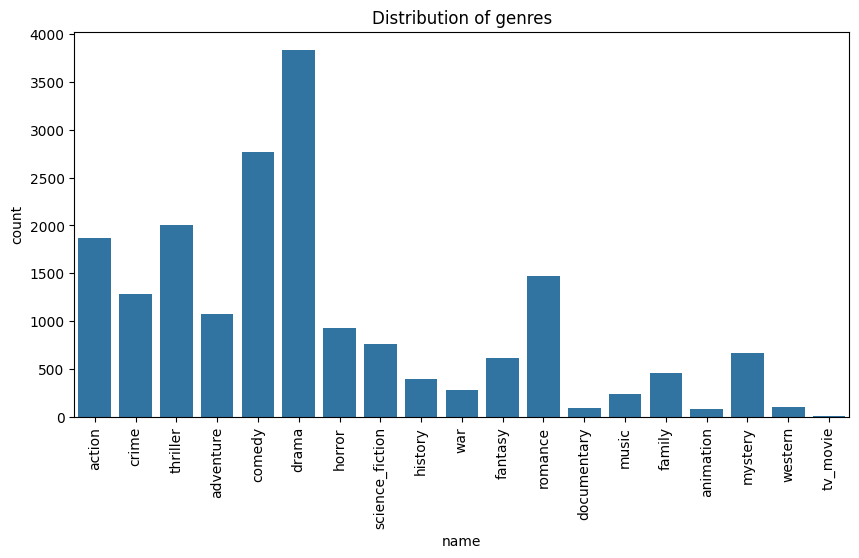

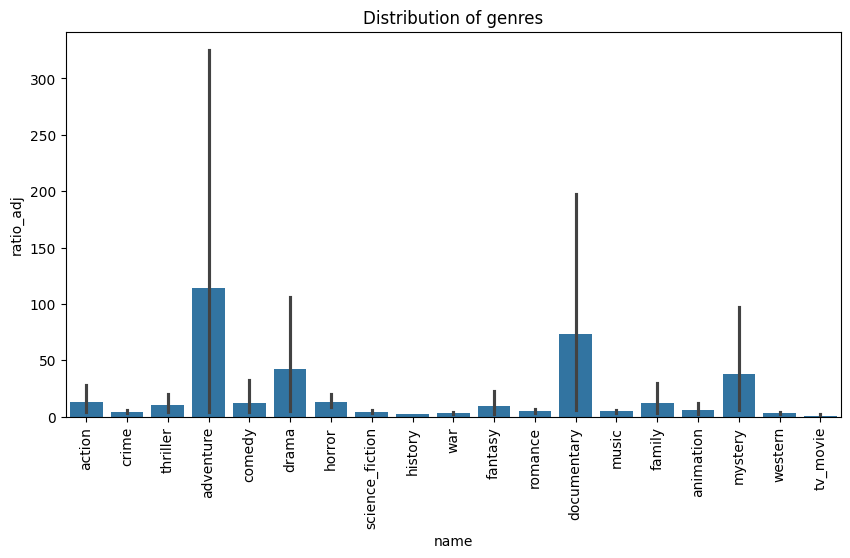

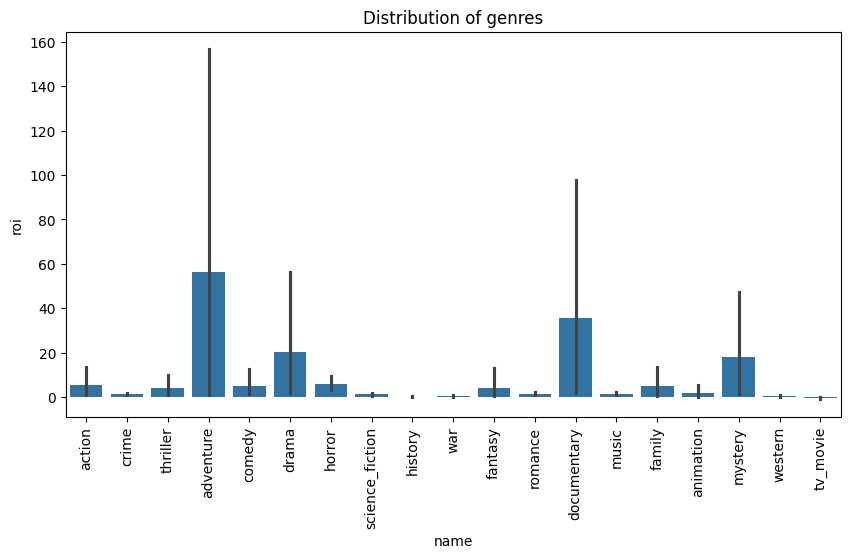

In [40]:
# Distribution of the genres?
plt.figure(figsize=(10, 5))
plt.title('Distribution of genres')
sns.countplot(data=movie_genre, x='name')
plt.xticks(rotation=90)
plt.show()

# Average ratio per genre
plt.figure(figsize=(10, 5))
plt.title('Distribution of genres')
sns.barplot(data=movie_genre, x='name', y='ratio_adj')
plt.xticks(rotation=90)
plt.show()

# Average ROI per genre
plt.figure(figsize=(10, 5))
plt.title('Distribution of genres')
sns.barplot(data=movie_genre, x='name', y='roi')
plt.xticks(rotation=90)
plt.show()

# Production Companies

In [41]:
# Join the movie and the production companies table
movie_production_companies = movie.merge(production_companies, how='left', on='movie_id')

In [42]:
# Number of production companies
print('Number of production companies: ', len(movie_production_companies['company_name'].unique()))
# Number of parent companies (companies that own other companies)
print('Number of parent companies: ', len(movie_production_companies['parent_name'].unique()))

Number of production companies:  8415


KeyError: 'parent_name'

In [ ]:
# Number of production companies per movie
print('Number of production companies per movie: {0:.2f}'.format(movie_production_companies.groupby('movie_id')['company_name'].count().mean()))

Number of production companies per movie: 2.59


In [ ]:
# Biggest production companies (by number of movies and by revenue)
biggest_companies = movie_production_companies.groupby('company_name').agg({'movie_id': 'count', 'revenue_usd_adj': 'sum'})
biggest_companies.columns = ['Number of Movies', 'Total Revenue']
biggest_companies = biggest_companies.sort_values(by='Number of Movies', ascending=False).head(10)
display(biggest_companies)

,Number of Movies,Total Revenue
company_name,,
warner_bros_pictures,558,1.284086e+11
universal_pictures,548,1.149180e+11
columbia_pictures,426,8.351076e+10
paramount,414,9.708118e+10
20th_century_fox,360,1.017415e+11
canal_,246,1.223147e+10
new_line_cinema,245,4.142687e+10
metro_goldwyn_mayer,206,2.523969e+10
touchstone_pictures,176,2.762189e+10


In [ ]:
# Biggest parent production companies (by number of movies and by revenue)
biggest_parent_companies = movie_production_companies.groupby('parent_name').agg({'movie_id': 'count', 'revenue_usd_adj': 'sum'})
biggest_parent_companies.columns = ['Number of Movies', 'Total Revenue']
biggest_parent_companies = biggest_parent_companies.sort_values(by='Number of Movies', ascending=False).head(10)
display(biggest_parent_companies)

,Number of Movies,Total Revenue
parent_name,,
warner_bros_entertainment,619,1.345778e+11
universal_pictures,550,1.149332e+11
columbia_pictures,426,8.351076e+10
sony_pictures,375,7.149488e+10
20th_century_fox,362,1.017880e+11
new_line_cinema,277,4.186632e+10
canal_,246,1.223147e+10
walt_disney_pictures,194,9.478674e+10
touchstone_pictures,176,2.762189e+10


In [ ]:
# Companies with the most subsidiaries
subsidiaries = movie_production_companies.groupby('parent_name').agg({'company_name': 'nunique'})
subsidiaries.columns = ['Number of Subsidiaries']
subsidiaries = subsidiaries.sort_values(by='Number of Subsidiaries', ascending=False).head(10)
display(subsidiaries)

,Number of Subsidiaries
parent_name,
sony_pictures,4
universal_pictures,3
walt_disney_pictures,2
europacorp,2
new_line_cinema,2
warner_bros_entertainment,2
lotte_entertainment,2
ard,2
regency_enterprises,2


# Keywords

In [ ]:
movie_keywords = movie.merge(keywords, how='left', on='movie_id')

In [ ]:
# Lets do some EDA on the keywords
# How many keywords are there?
print('Number of keywords: ', len(movie_keywords['keyword_name'].unique()))

Number of keywords:  13264


In [ ]:
# On average, how many keywords are there per movie?
print('Average number of keywords per movie: ', movie_keywords.groupby('movie_id')['keyword_name'].count().mean())

Average number of keywords per movie:  5.773925663146013


In [ ]:
# The most popular keywords (by number of movies and by revenue)
popular_keywords = movie_keywords.groupby('keyword_name').agg({'movie_id': 'count', 'revenue_usd_adj': 'sum'})
popular_keywords.columns = ['Number of Movies', 'Total Revenue']
popular_keywords = popular_keywords.sort_values(by='Number of Movies', ascending=False).head(10)
display(popular_keywords)

,Number of Movies,Total Revenue
keyword_name,,
woman_director,910,3.844783e+10
based_on_novel_or_book,689,1.067327e+11
murder,499,3.613751e+10
duringcreditsstinger,386,1.106263e+11
independent_film,374,3.074507e+09
violence,364,4.324068e+10
new_york_city,325,4.657788e+10
based_on_a_true_story,309,2.985410e+10
biography,309,1.937282e+10


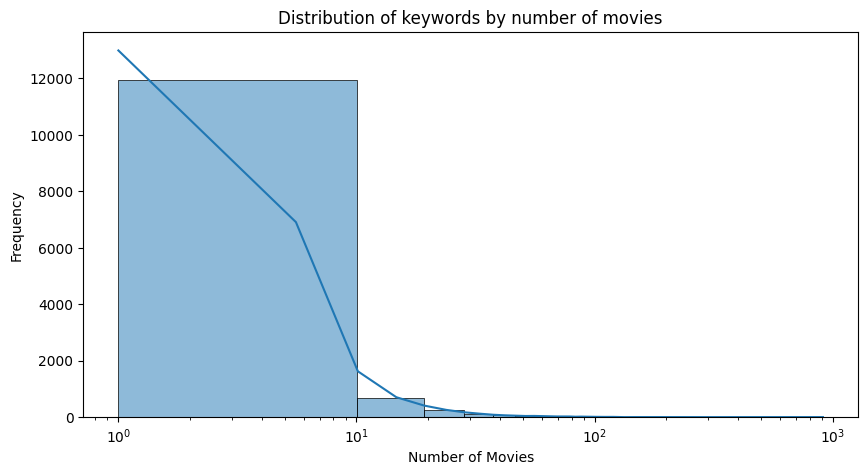

In [ ]:
# Can we do a histogram for the distribution of keywords by the number of movies they appear in? Lets do it in log scale
# Can we also show the cumulative distribution?
plt.figure(figsize=(10, 5))
plt.title('Distribution of keywords by number of movies')
sns.histplot(movie_keywords.groupby('keyword_name')['movie_id'].count(), bins=100, kde=True)
plt.xlabel('Number of Movies')
plt.ylabel('Frequency')
plt.xscale('log')
plt.show()


# Time analysis

In [ ]:
plot_and_export_categorical_distribution(movie, 'year', 0, "linear", False)

,grouped,total
0,1970,9
1,1971,11
2,1972,11
3,1973,10
4,1974,6
5,1975,12
6,1976,10
7,1977,9
8,1978,20
9,1979,24


In [ ]:
plot_and_export_categorical_distribution(movie, 'quarter', 0, "linear", False)

,grouped,total
0,1,2917
1,2,2763
2,3,3340
3,4,3383


In [ ]:
plot_and_export_categorical_distribution(movie, 'month', 0, "linear", False)

,grouped,total
0,1,983
1,2,905
2,3,1029
3,4,951
4,5,939
5,6,873
6,7,795
7,8,1048
8,9,1497
9,10,1309
